In [165]:
import numpy as np
import os
import pickle
from utilities_ketamine_analysis_v8 import *
from utils_signal_processing import *
from utils_plotting import *
from utils_general import *
from scipy.signal import morlet

#### HPC start and end indexes

In [ ]:
# HPC start and end 
ch_start = 75*2
ch_end = 131*2

### Load behavior for all sessions

In [64]:
speed_path = r'C:\Users\fentonlab\Desktop\Gino\behaviour\\'
x = np.load(os.path.join(speed_path, "x_aln.npy"), allow_pickle=True)
y = np.load(os.path.join(speed_path, "y_aln.npy"), allow_pickle=True)
speed = np.load(os.path.join(speed_path, "speed_aln.npy"), allow_pickle=True)
yaw = np.load(os.path.join(speed_path, "yaw_aln.npy"), allow_pickle=True)

In [65]:
beh_binned_all = []

for ipath in range(0,len(x)):
    # print(ipath)
    
    behavior_con = []
    behavior_con = np.array([x[ipath],y[ipath],yaw[ipath],speed[ipath]])
    
    beh_binned_all.append(behavior_con)

### Load paths and ephys files for spiking activity

In [5]:
out_path = Path(r'C:\Users\fentonlab\Desktop\Gino\HPC_channel_info\\')

sync_PATH = os.path.join(out_path,'sync_path_matched.pkl')
nt_PATH = os.path.join(out_path,'nt_path_matched.pkl')
ksort_PATH = os.path.join(out_path,'ksort_HPC_path_matched.pkl')
ts_ephys_PATH = os.path.join(out_path,'ts_ephys_aln.pkl')

with open(sync_PATH,'rb') as file:
    sync_path_matched = pickle.load(file)
    
with open(nt_PATH,'rb') as file:
    nt_path_matched= pickle.load(file)
    
with open(ksort_PATH,'rb') as file:
    ksort_HPC_path_matched = pickle.load(file)
    
with open(ts_ephys_PATH,'rb') as file:
    ts_ephys_aln = pickle.load(file)


In [6]:
sess = 2

### Load spike files for a given session (takes about 3 min)

In [7]:
# load HPC file names and store them in rec spikes at 250 Hz
path_spike = Path(r'Z:\NeuroPix\spk_ketamine\HPC\\')
rec_name = 'spk_250Hz_' + str(sess) + '.file'
spk_file_name = os.path.join(path_spike , rec_name)

with open(spk_file_name,'rb') as f:
    spikes_binned_all_HPC = pickle.load(f)
    
# load behavior and upsample to 250Hz

In [9]:
# check dimension of spikes and behaviour (at 100 Hz)
spikes_binned_all_HPC[0].shape[1], x[0].shape, speed[0].shape

(1800499, (720214,), (720214,))

In [10]:
spk = spikes_binned_all_HPC

### Load LFP for a given session -- Only CA1

#### Define paths and load

In [36]:
import h5py

def load_h5_file(filepath):
    data = {}
    with h5py.File(filepath, 'r') as f:
        # List all groups
        print("Keys: %s" % f.keys())
        for key in f.keys():
            # Get the data
            data[key] = f[key][:]
    return data

In [66]:
# binFullPath = r'C:\Users\fentonlab\Desktop\Gino\LFPs'
# main_dir = r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC'
# HPC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','HPC_lfp_paths.file')
# PFC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','PFC_lfp_paths.file')

# # ====== Load Lfp and speed data for a specific recording and brain area 
# rec = load_rec_path(binFullPath,HPC_path_file,PFC_path_file,"HPC",sess)
# path = rec[sess]['HPC']
# dir_sess = path.split('\\')[-3] # path for session directory
# full_dir_path = os.path.join(main_dir,dir_sess)
# out_file = os.path.join(full_dir_path, "lfp_epoch_all_trials_all_ch.h5")
# # lfp = loadmat(out_file)
# lfp = load_h5_file(out_file)

In [108]:
binFullPath = r'C:\Users\fentonlab\Desktop\Gino\LFPs'
main_dir = r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC'
HPC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','HPC_lfp_paths.file')
PFC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','PFC_lfp_paths.file')

# ====== Load Lfp and speed data for a specific recording and brain area 
rec = load_rec_path(binFullPath,HPC_path_file,PFC_path_file,"HPC",sess)
path = rec[sess]['HPC']
dir_sess = path.split('\\')[-3] # path for session directory
full_dir_path = os.path.join(main_dir,dir_sess)
out_file = os.path.join(full_dir_path, "lfp_epoch_all_trials_CA1.mat")
lfp = loadmat(out_file)

Loading file in:  Z:\NeuroPix\Ketamine\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_g0_imec1\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_g0_t0.imec1.lf.bin


In [109]:
lfp_B = lfp['lfp_all']['B'][0][0]
lfp_L = lfp['lfp_all']['L'][0][0]
lfp_M = lfp['lfp_all']['M'][0][0]
lfp_H = lfp['lfp_all']['H'][0][0]

In [110]:
# min, length of 60 sec recording at 1250 Hz, channel
lfp_B.shape

(20, 75000, 20)

### Load low/high speed masks for a given session

In [111]:
out_file = os.path.join(full_dir_path, "mask_low_high_speed.mat")
mask = loadmat(out_file)

In [112]:
# lfp['lfp']['M'][0][0][0][1].shape # ntrials, T (1 sec)
# lfp['lfp']['B'][0][0][0][0][0].shape # nmin
# lfp['lfp']['B'][0][0][0].shape # nch
# lfp['lfp']['B'][0][0][0][0][0][0] # ntrials, T (1 sec)

In [113]:
mask_B = mask['mask']['B_low'][0][0]
mask_L = mask['mask']['L_low'][0][0]
mask_M = mask['mask']['M_low'][0][0]
mask_H = mask['mask']['H_low'][0][0]

In [115]:
# min, 60 sec of mask - one element for each second, channel
mask_B.shape

(20, 60, 20)

In [30]:
## load spk files
## load behavior at 100 Hz
## upsample behavior to 250Hz
## load lfp at 250 hz of that recording

In [31]:
## spk_mask = true/false per cell when it spikes at 250 Hz
## phase_mask = hilbert transform of lfp to phase at 250Hz per frequency band (every 4-8 Hz)
## histogram1D with spk_mask as weights


#### Upsample behavior at 250 Hz (input at 100 Hz)

In [95]:
def upsample_behaviour(spk, speed, x, y, sess, spk_rate = 250, behav_rate = 100):
    
    # time length for speed and spike variables
    behav_T = np.linspace(0, len(speed[sess])/ behav_rate, len(speed[sess]))
    spk_T = np.linspace(0, spk[0].shape[1]/ spk_rate, spk[0].shape[1]) # all cells have same time length

    # interpolate speed variable based on spike 
    interpolator = interp1d(behav_T, speed[sess], kind = 'linear', fill_value="extrapolate")
    speed_upsampled = interpolator(spk_T)
    
    # interpolate x variable based on spike 
    interpolator = interp1d(behav_T, x[sess], kind = 'linear', fill_value="extrapolate")
    x_upsampled = interpolator(spk_T)
    
    # interpolate y variable based on spike 
    interpolator = interp1d(behav_T, y[sess], kind = 'linear', fill_value="extrapolate")
    y_upsampled = interpolator(spk_T)
    
    # check if upsample done correctly
    if (speed_upsampled.size - spk[0].shape[1]) !=0:
        sys.exit("Speed upsampled size and spike size are not the same!")
    print('speed upsampled shape {}, spike shape {}'.format(speed_upsampled.shape, spk[0].shape))
    
    return speed_upsampled, x_upsampled, y_upsampled

In [96]:
speed_up, x_up, y_up = upsample_behaviour(spk, speed, x, y, sess)
beh_data = [None,None]
beh_data[0] = x_up
beh_data[1] = y_up

speed upsampled shape (1800499,), spike shape (223, 1800499)


#### Subsample Lfp at 250 Hz (input at 1250 Hz)

In [122]:
LfpSB = lfp_B[:,::5,:] # original Lfp is sampled at 1250 Hz 
LfpSL = lfp_L[:,::5,:] 
LfpSM = lfp_M[:,::5,:] 
LfpSH = lfp_H[:,::5,:] 
LfpSB.shape

(20, 15000, 20)

In [127]:
# spike time of cell 0
spk[0][0][0:1000]
# mapping array between cell number and LFP channel
spk[2][:]

array([  2,   1,   5,   2,   8,   6,   7,   7,   6,  12,   9,  11,  10,
         7,   8,   9,   7,  10,  11,  11,  15,  13,  12,  12,  14,  17,
        20,  17,  17,  17,  21,  21,  21,  21,  23,  21,  22,  26,  28,
        27,  27,  27,  26,  26,  26,  27,  30,  28,  28,  27,  27,  37,
        34,  33,  32,  32,  37,  41,  40,  41,  39,  44,  41,  41,  48,
        47,  47,  46,  50,  50,  55,  52,  53,  52,  55,  55,  53,  52,
        53,  53,  57,  59,  61,  61,  63,  63,  67,  69,  67,  68,  67,
        69,  71,  71,  70,  73,  72,  73,  72,  73,  73,  81,  76,  77,
        82,  83,  85,  83,  84,  85,  86,  85,  87,  89,  88,  89,  85,
        84,  86,  86,  89,  89,  89,  89,  88,  95, 100,  99, 100, 105,
       100, 100, 100, 108, 113, 116, 121, 118, 127, 130, 132, 128, 128,
       132, 135, 132, 135, 132, 132, 132, 134, 136, 136, 136, 139, 136,
       138, 146, 151, 148, 148, 151, 154, 149, 150, 167, 173, 172, 175,
       180, 179, 178, 179, 188, 188, 190, 192, 193, 194, 200, 19

### Find spike-cell index for cells in CA1 associated to at least one LFP channel

In [163]:
# CA1 start and ending point, with the fulling labeling (all electrodes)
condition = (spk[2] >= CA1_start) & (spk[2] <= CA1_end) # get map of cells in CA1
idx_cell_CA1 = np.where(condition)[0] # get index of cells in CA1
print("Lfp channel in full labeling: ", spk[2][idx_cell_CA1]) # print LFP channel in CA1
print("Cell index in full labeling:  ", idx_cell_CA1) # print cell index 
spk[2][idx_cell_CA1] - CA1_start # get index of cells in CA1, mapped to the LFP indexing 


Lfp channel in full labeling:  [151 151 154 150 167]
Cell index in full labeling:   [158 161 162 164 165]


array([ 1,  1,  4,  0, 17], dtype=int64)

In [162]:
mapd = {
    'lfp_ch': spk[2][idx_cell_CA1] - CA1_start, # lfp channel, with the mapping from 0 to N in CA1 (0 is the first CA1 channel)
     'cell_id': idx_cell_CA1 # id cell in CA1 associated to a given Lfp channel
}
mapd

{'lfp_ch': array([ 1,  1,  4,  0, 17], dtype=int64),
 'cell_id': array([158, 161, 162, 164, 165], dtype=int64)}

### Cell density associated to a given LFP -- how many cells for an LFP channel 

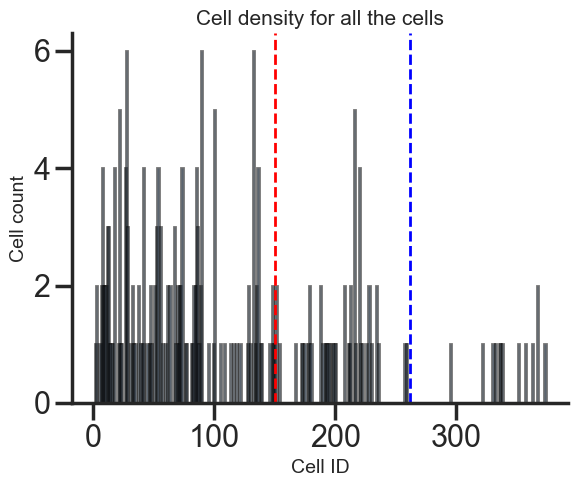

In [129]:
hist, bin_edges = np.histogram(spk[2], bins=374)
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.55)
plt.axvline(x=ch_start, color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=ch_end, color='blue', linestyle='dashed', linewidth=2)

plt.xlabel('Cell ID',fontsize=14)
plt.ylabel('Cell count',fontsize=14)
plt.title('Cell density for all the cells',fontsize=15)
plt.show()

In [82]:
# Path for the session currently being analyzed
ksort_HPC_path_matched[sess]

WindowsPath('C:/Users/fentonlab/Desktop/Tony/Neurotar_HPC_ketamine/SPK/electrophysiology/2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe')

In [178]:
# from scipy.signal import hilbert

# """
# Scale Lfp into mV and band pass it at [1,300] Hz by using a non-causal filter
# Apply notch filter at 60 Hz to remove power line distortion
# """

# def filter_lfp_in_each_epoch_and_frequency(Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, lowcut, highcut, gain, fs = 250):

#     print('Filtering Lfp ...')
    
#     # baseline
#     lfp_scaled_B = Lfp_B_min*gain*1e6 # scale in uV
#     lfp_filt_B_bp = bandpass_filter(lfp_scaled_B, lowcut, highcut, fs, order=5) # band pass filter at 1 Hz and 300 Hz
    
#     # low injection 
#     lfp_scaled_L = Lfp_L_min*gain*1e6 # scale in uV
#     lfp_filt_L_bp = bandpass_filter(lfp_scaled_L, lowcut, highcut, fs, order=5) # band pass filter at 1 Hz and 300 Hz
    
#     # mid injection 
#     lfp_scaled_M = Lfp_M_min*gain*1e6 # scale in uV
#     lfp_filt_M_bp = bandpass_filter(lfp_scaled_M, lowcut, highcut, fs, order=5) # band pass filter at 1 Hz and 300 Hz
    
#     # high injection 
#     lfp_scaled_H = Lfp_H_min*gain*1e6 # scale in uV
#     lfp_filt_H_bp = bandpass_filter(lfp_scaled_H, lowcut, highcut, fs, order=5) # band pass filter at 1 Hz and 300 Hz

#     return lfp_filt_B_bp, lfp_filt_L_bp, lfp_filt_M_bp, lfp_filt_H_bp

# # =============================================================================

# """
# Apply notch filter at 60 Hz (power line)
# """

# def filter_lfp_notch_filter(lfp_filt_B_bp, lfp_filt_L_bp, lfp_filt_M_bp, lfp_filt_H_bp, qband, fs =250):

#     print('Filtering Lfp ...')
    
#     # baseline
#     lfp_filt_B = notch_filter(lfp_filt_B_bp, 60, fs, Q=qband)
    
#     # low injection 
#     lfp_filt_L = notch_filter(lfp_filt_L_bp, 60, fs, Q=qband)
    
#     # mid injection 
#     lfp_filt_M = notch_filter(lfp_filt_M_bp, 60, fs, Q=qband)
    
#     # high injection 
#     lfp_filt_H = notch_filter(lfp_filt_H_bp, 60, fs, Q=qband)

#     return lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H

# # =============================================================================
# """
# Extract the instantaneous phase of an LFP signal using the Hilbert transform.
# Inputs: lfp_signal: A 2D numpy array of shape (T, nch), where T is the number of time points 
#               and nch is the number of channels.
# Outputs: instantaneous_phase: A 2D numpy array of the same shape as lfp_signal containing 
#                        the instantaneous phase for each channel in degrees [0, 360] range
# """

# def instantaneous_phase(lfp_signal):

#     # Apply the Hilbert transform to each channel
#     analytic_signal = hilbert(lfp_signal, axis=0)
#     # Calculate the instantaneous phase in radiants
#     instantaneous_phase = np.angle(analytic_signal)
#     # Convert to degrees
#     instantaneous_phase = np.degrees(instantaneous_phase)
#     instantaneous_phase = instantaneous_phase % 360  # Wrap to 0-360 degrees
    
#     return instantaneous_phase

# # =============================================================================

# """
# Compute the instantaneous phase for each one of the epochs (baseline, low, mid, high dosage)
# """

# def instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H):
    
#     phase_B = instantaneous_phase(lfp_filt_B)
#     phase_L = instantaneous_phase(lfp_filt_L)
#     phase_M = instantaneous_phase(lfp_filt_M)
#     phase_H = instantaneous_phase(lfp_filt_H)
    
#     return phase_B, phase_L, phase_M, phase_H

In [267]:
t = np.linspace(0,1250,1250)
LfpSB[minute,0:sampling*2,ch].size

2500

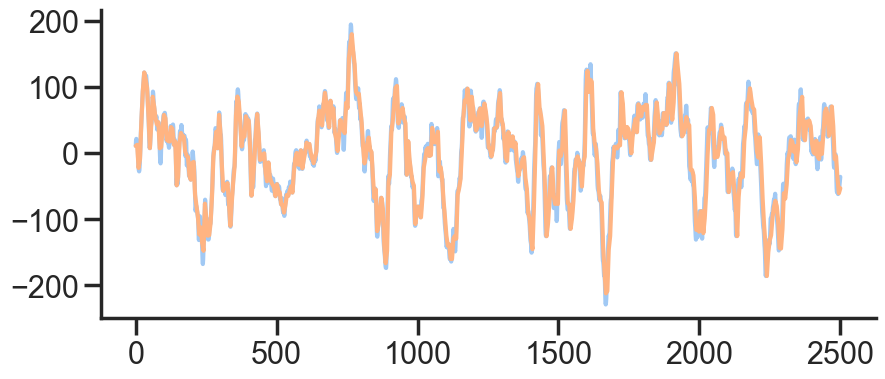

In [269]:
minute = 0
ch = 0
sampling = 1250
t = np.linspace(0,2*sampling,2*sampling)
t_down = np.linspace(0,2*sampling,int(2*sampling/5))

plt.figure(figsize=(10,4))
plt.plot(t,lfp_B[minute,0:sampling*2,ch])
plt.plot(t_down,LfpSB[minute,0:250*2,ch])

### Extract instantaneous phase using a Morlet transform from LFP signal

#### frequency in logscale for spike-LFP analysis

In [270]:
# frequency range values 
freq = np.logspace(1, 100, num=50, endpoint=True, base=10.0, dtype=None)
# freq

#### Function to extract instantaneous phase from Morlet Wavelet

In [298]:
def get_instantaneous_phase(lfp_signal, frequencies):
    T, nch = lfp_signal.shape
    phase_data = np.zeros((len(frequencies), T, nch))
    wavelist = []
    for f_idx, freq in enumerate(frequencies):
        wavelet = morlet(M=T, w=2*np.pi*freq, s=1, complete=True)
        wavelist.append(wavelet)
        for ch in range(nch):
            convolution = np.convolve(lfp_signal[:, ch], wavelet, 'same')
            phase_data[f_idx, :, ch] = np.angle(convolution)
    
    return phase_data, wavelist 

In [302]:
def get_phase_single_value(lfp_signal, freq):
    T = lfp_signal.size
    wavelet = morlet(M=T, w=2*np.pi*freq, s=1, complete=True)
    convolution = np.convolve(lfp_signal, wavelet, 'same')
    phase_data = np.angle(convolution)
    
    return phase_data, wavelet

In [230]:
lfp_signal.shape[0], lfp_B.shape

(500, (20, 75000, 20))

In [300]:
# Example usage:
minute = 0
sampling_rate = 1250  # Replace with your actual sampling rate
lfp_signal_full = lfp_B[minute,0:1250*2,:]  # Replace with your actual LFP signal
phase_data_full, wavelet_full = get_instantaneous_phase(lfp_signal_full, freq)
phase_data_full.shape, len(wavelet_full), wavelet_full[0].shape

((50, 2500, 20), 50, (2500,))

In [232]:
# Example usage:
minute = 0
sampling_rate = 250  # Replace with your actual sampling rate
lfp_signal = LfpSB[minute,0:250*2,:]  # Replace with your actual LFP signal
phase_data, wavelet = get_instantaneous_phase(lfp_signal, freq, sampling_rate)
phase_data.shape, len(wavelet), wavelet[0].shape

((50, 500, 20), 50, (500,))

IndexError: index 2 is out of bounds for axis 2 with size 1

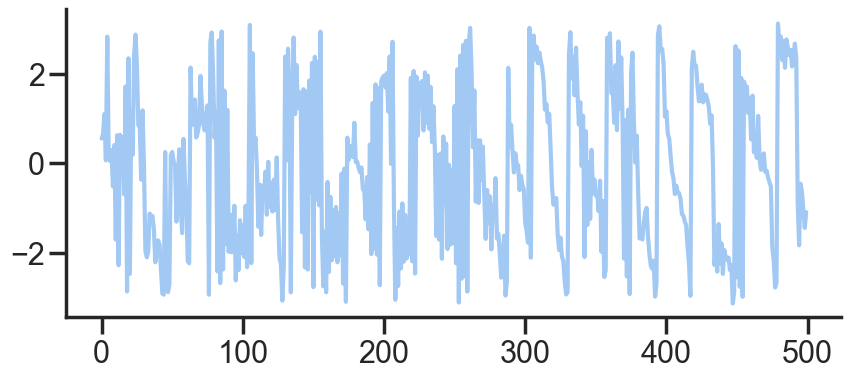

In [301]:
# You can then plot the phase for a specific frequency and channel if needed:
freq_ind = 20

# First plot
plt.figure(figsize=(10, 4))
plt.plot(phase_data_full[freq_ind, ::5, 2])
plt.plot(phase_data[freq_ind, :, 2])
plt.xlim([0, 250])
plt.legend(['1250 Hz', '250 Hz'], fontsize=11)
plt.title('Instantaneous phase vs time at given freq', fontsize=14)
plt.show()

# Second plot
plt.figure()
plt.plot(wavelet_full[freq_ind][::5].real, label='real')
plt.plot(wavelet_full[freq_ind][::5].imag, label='imag')
plt.legend(fontsize=11)
plt.title('Morlet transform for Lfp at 1250 Hz', fontsize=14)
plt.show()

# Third plot
plt.figure()
plt.plot(wavelet[freq_ind][:].real, label='real')
plt.plot(wavelet[freq_ind][:].imag, label='imag')
plt.legend(fontsize=11)
plt.title('Morlet transform for Lfp at 250 Hz', fontsize=14)
plt.show()


In [224]:
LfpSB.shape, lfp_B.shape

((20, 15000, 20), (20, 75000, 20))

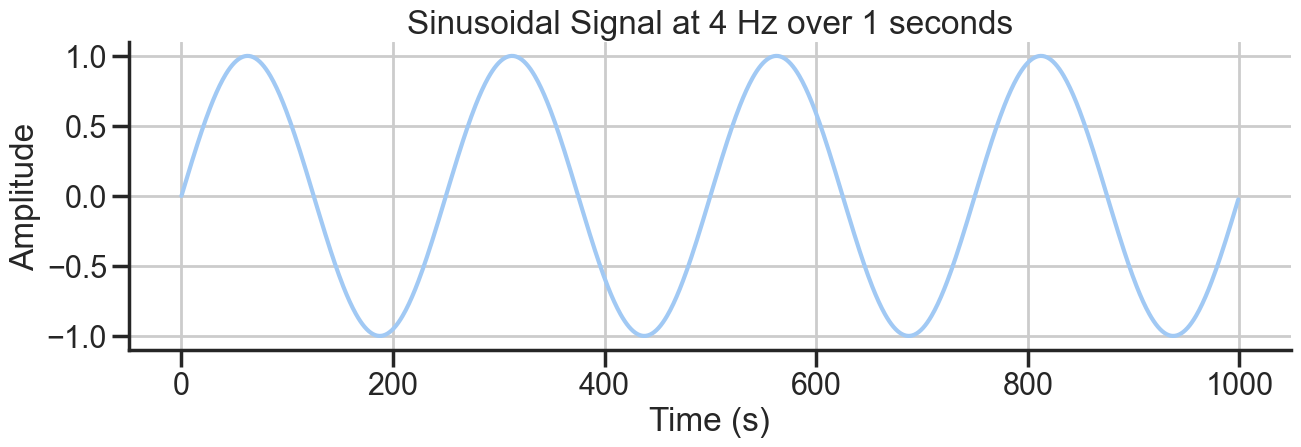

In [308]:

# Define the parameters for the signal generation
frequency = 4  # Frequency of the sinusoidal function in Hz
T = 1  # Time length of the signal in seconds
sampling_rate = 1000  # Sampling rate in Hz

# Generate the time vector
t = np.linspace(0, T, int(T * sampling_rate), endpoint=False)
# Generate the sinusoidal signal
signal = np.sin(2 * np.pi * frequency * t)

# Plot the signal
plt.figure(figsize=(15, 4))
plt.plot(signal)
plt.title(f'Sinusoidal Signal at {frequency} Hz over {T} seconds')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [306]:
phase_data, wavelet = get_phase_single_value(signal, frequency)
phase_data.shape, len(wavelet), wavelet[0].shape

((1000,), 1000, ())

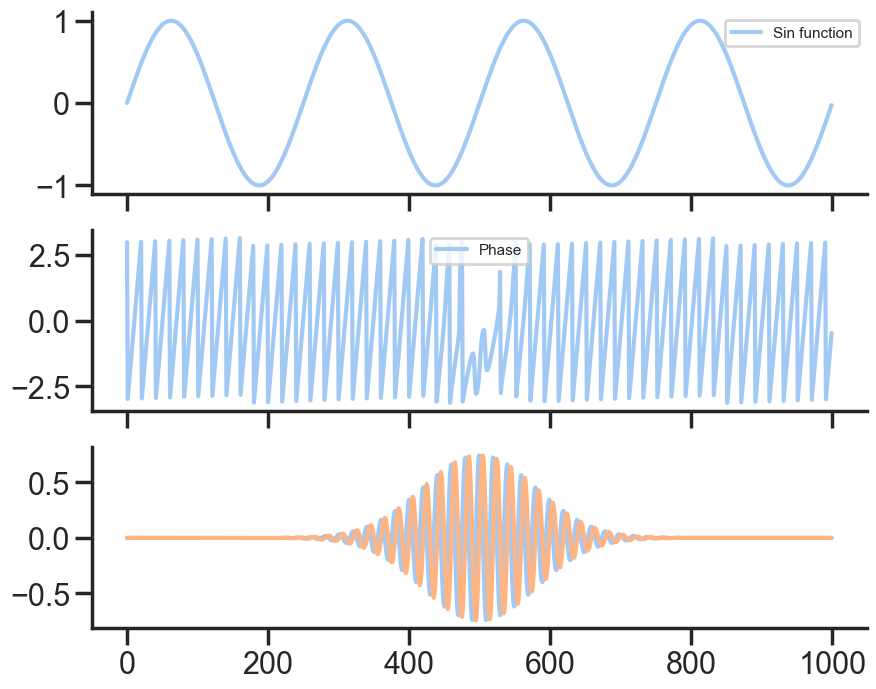

In [327]:
# First plot

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)  # Share x-axis
fig.set_size_inches(10, 8)

ax1.plot(signal)
ax1.legend(['Sin function'], fontsize=11)
# xticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# xlabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$']
# plt.xticks(xticks, xlabels)  # Set y-ticks and y-labels
# ax1.set_xlim([0, 500])

ax2.plot(phase_data)
ax2.legend(['Phase'], fontsize=11)
# ax2.set_title('Instantaneous phase vs time at given freq', fontsize=14)
yticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
ylabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$']
# ax2.yticks(yticks, ylabels)  # Set y-ticks and y-labels
# ax2.set_xlim([0, 500])


# Second plot
ax3.plot(wavelet.real, label='real')
ax3.plot(wavelet.imag, label='imag')
# plt.legend(fontsize=11)
# plt.title('Morlet transform for Sin function', fontsize=14)
plt.show()

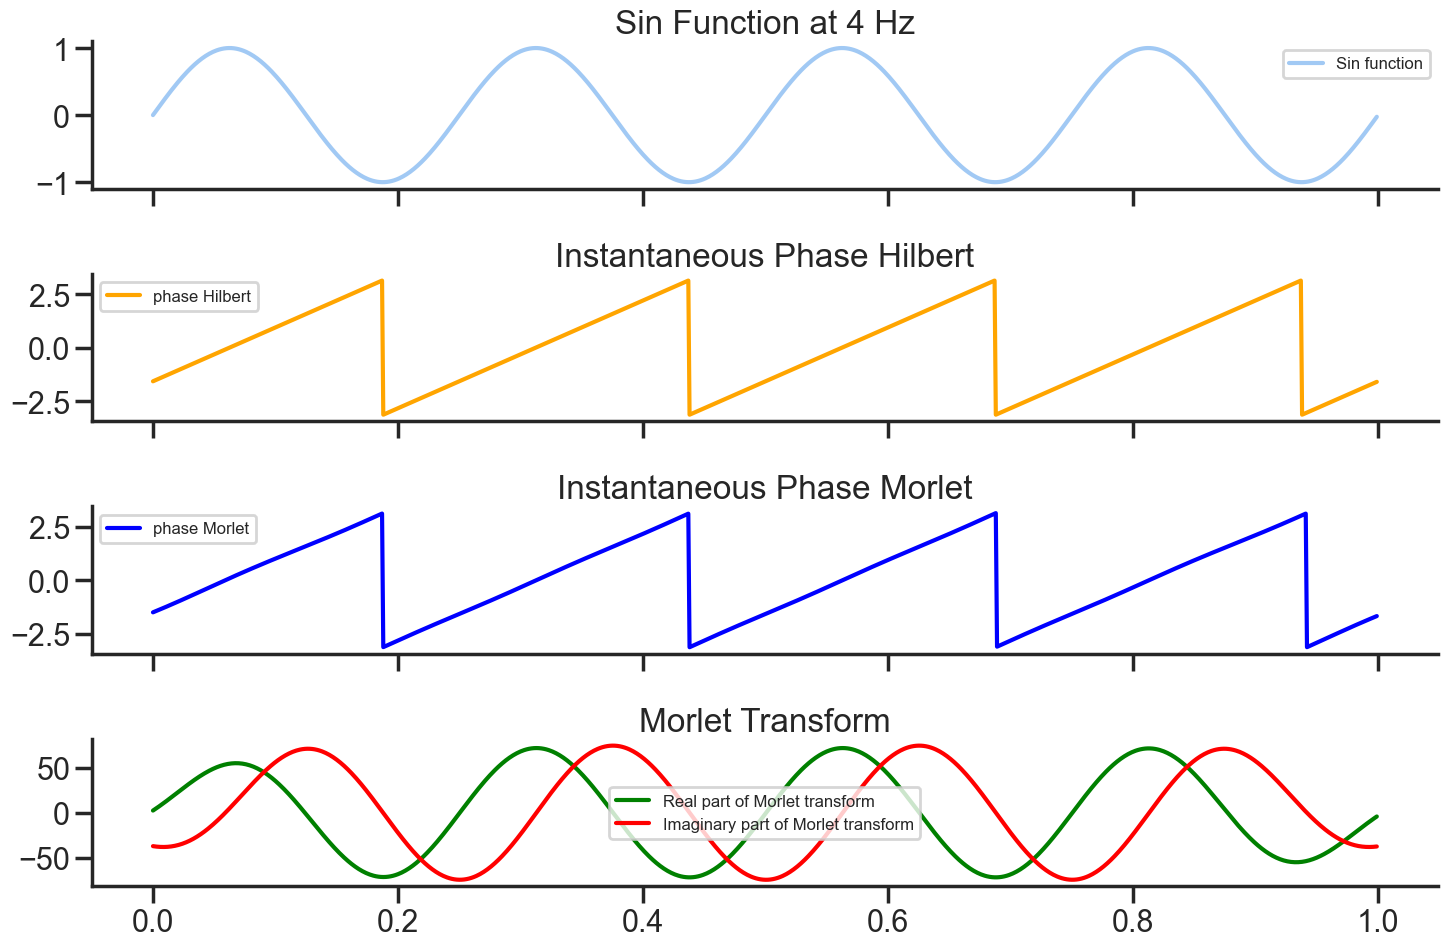

In [352]:
from scipy.signal import morlet, hilbert

# Constants
fs = 1000  # Sampling frequency in Hz
f = 4  # Frequency of the sin function in Hz
T = 1 / f  # Period of the sin function
N = int(4 * T * fs)  # Number of time points for 4 full oscillations

# Time vector for N time points
t = np.arange(N) / fs

# Generate a sin function at 4 Hz
sin_wave = np.sin(2 * np.pi * f * t)

# Compute the Morlet wavelet transform (a complex representation)
# widths = np.arange(1, 31)
morlet_wave = morlet(N, w=2, s=1.0)  # w is the width parameter, s is the scaling factor
# morlet_wave = morlet(N, w=2*np.pi*f, s=7/(2*np.pi*f), complete=True)

# Convolve the Morlet wavelet with the sin wave to get the complex signal
morlet_transform = np.convolve(sin_wave, morlet_wave, mode='same')
# Extract the instantaneous phase using Morlet transform
phase_morlet = np.angle(morlet_transform)

# Extract the instantaneous phase using Hilbert transform
analytic_signal = hilbert(sin_wave)
phase_hilbert = np.angle(analytic_signal)

# Plot the sin function, the phase, and the Morlet transform
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.set_size_inches(15, 10)

# Sin function
axs[0].plot(t, sin_wave, label='Sin function')
axs[0].set_title('Sin Function at 4 Hz')
axs[0].legend(fontsize=12)

# Instantaneous phase Hilbert 
axs[1].plot(t, phase_hilbert, label='phase Hilbert', color='orange')
axs[1].set_title('Instantaneous Phase Hilbert')
axs[1].legend(fontsize=12)

# Instantaneous phase Morlet
axs[2].plot(t, phase_morlet, label='phase Morlet', color='blue')
axs[2].set_title('Instantaneous Phase Morlet')
axs[2].legend(fontsize=12)

# Morlet transform
axs[3].plot(t, morlet_transform.real, label='Real part of Morlet transform', color='green')
axs[3].plot(t, morlet_transform.imag, label='Imaginary part of Morlet transform', color='red')
axs[3].set_title('Morlet Transform')
axs[3].legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


In [296]:
signal_ch = signal[:,np.newaxis]
phase_data, wavelet = get_instantaneous_phase(signal_ch, frequency, sampling_rate)
print(phase_data.shape, len(wavelet), wavelet[0].shape)

# You can then plot the phase for a specific frequency and channel if needed:
# freq_ind = 2
# plt.figure(figsize=(14,4))
# plt.plot(phase_data[freq_ind, :, 0])
# plt.show()
# plt.plot(wavelet[freq_ind].real, label="real")
# plt.plot(wavelet[freq_ind].imag, label="imag")
# plt.legend()
# plt.show()

TypeError: object of type 'int' has no len()

In [393]:
# cell = 0 # cell ID
# lfp_ch = spk[2][cell] # Lfp ID corresponding to that given cell 
# print(lfp_ch)

# # list of frequency ranges 
# combined_freq = [np.array([1, 3])]
# combined_freq += [np.array([i, i+2]) for i in range(4, 52, 4)]
# combined_freq += [np.array([i, i+10]) for i in range(52, 95, 5)]
# freq = np.array(combined_freq)
# for fmin, fmax in freq:
#     print(fmin,fmax)

In [269]:
current_min = 10 
# ====== Select 1 min data 
Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, speed_B_min, speed_L_min, speed_M_min, speed_H_min = \
    select_1min_data(Lfp_B, Lfp_L, Lfp_M, Lfp_H, speed_B, speed_L, speed_M, speed_H, current_min, N=250)

# ====== Replace Lfp bad channel with nearest neighbor (if bad channel exists)
if bad_flag:
    Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min = replace_bad_lfp_channel(Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, bad_id, next_id)

1 min data: Lfp shape (15000, 112), speed shape (15000,), length in sec: 60.0



In [255]:
# filter Lfp at a given epoch 
# lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, 1, 4, gain)
# phase_B_freq, phase_L_freq, phase_M_freq, phase_H_freq = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H) 
# phase_B.append(phase_B_freq)

Filtering Lfp ...


In [274]:
# lists for instantaneous phase 
phase_B, phase_L, phase_M, phase_H = [], [], [], []
for fmin, fmax in freq:
    print("Freq {}-{}".format(fmin,fmax))
    # Band-Pass Lfp at a given frequency band, for each epoch
    lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, fmin, fmax, gain)
    if fmin >= 47 and fmax <= 73: # power line interference at 60 Hz 
        fp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_notch_filter(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H, 200)
        print("Notch filter for {}-{}".format(fmin,fmax))
    phase_B_freq, phase_L_freq, phase_M_freq, phase_H_freq = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H)
    phase_B.append(phase_B_freq)
    phase_L.append(phase_L_freq)
    phase_M.append(phase_M_freq)
    phase_H.append(phase_H_freq)

Freq 1-3
Filtering Lfp ...
Freq 4-8
Filtering Lfp ...
Freq 8-12
Filtering Lfp ...
Freq 12-16
Filtering Lfp ...
Freq 16-20
Filtering Lfp ...
Freq 52-62
Filtering Lfp ...
Filtering Lfp ...
Notch filter for 52-62
Freq 62-72
Filtering Lfp ...
Filtering Lfp ...
Notch filter for 62-72
Freq 72-82
Filtering Lfp ...
Freq 82-92
Filtering Lfp ...
Freq 92-102
Filtering Lfp ...


In [300]:
freq[:,0]

array([ 1,  4,  8, 12, 16, 52, 62, 72, 82, 92])

In [282]:
hist_B_list, hist_L_list, hist_M_list, hist_H_list = [], [], [], []
for f in range(len(phase_B)):
    hist_B, bin_edges = np.histogram(phase_B[f][:,lfp_ch], bins=30, range=[0, 360], weights=spk[0][cell][0:15000])
    hist_B_list.append(hist_B)
    hist_B_arr = np.array(hist_B_list)

In [164]:
pwd

'C:\\Users\\fentonlab\\Desktop\\Gino\\Gino_codes\\python'

In [ ]:
import h5py
import numpy as np

# Create a large matrix
large_matrix = np.random.rand(10000, 10000)

# Using h5py to save as HDF5, which MATLAB can read
with h5py.File('large_matrix.h5', 'w') as f:
    # Create a dataset in the file
    dset = f.create_dataset('large_matrix', data=large_matrix)

### Define function to identify place cells through firing rate maps

In [41]:
# CELL Properties 
# OUTPUT:
# occupation map, 
# rate_maps_temp (rate firing map -- raw, not smoothed)
# rate_maps_sm (rate firing map -- smoothed)
# LinMapsTemp_temp (rate firing map in 1D)

def place_cell_properties(spk_data, beh_data, binsxy, fsrate, shuf_state):
    from scipy.ndimage import gaussian_filter

    occ, rate_maps_sm, rate_maps_temp, LinMapsTemp_temp, p_info, coh = [], [], [], [], [], []
    nRepeat = 50  # number of shuffles

    # COMPUTING THE RATE MAPS
    occ = np.histogram2d(beh_data[0], beh_data[1], bins=binsxy)[0] / fsrate
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(occ, cmap='jet', ax=ax)    
    plt.show()
    
    # raw firing rate map
    rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                      / occ for s in spk_data]
    
#     ## radial version
#     Xcenter = beh_data[0] - (np.nanmax(beh_data[0]) + np.nanmin(beh_data[1])) / 2
#     Ycenter = beh_data[1] - (np.nanmax(beh_data[1]) + np.nanmin(beh_data[0])) / 2
    
#     alpha = np.arctan2(Ycenter, Xcenter)

#     L_occ = np.histogram(alpha, bins=binsxy)[0] /fsrate
    # LinMapsTemp_temp = [np.histogram(alpha, bins=30, weights=s)[0] / L_occ
    #      for s in spk_data]
    
    # get NaN index 
    idx_nan = [np.isnan(p) for p in rate_maps_temp]

    # smooth map 
    rate_maps_sm = [gaussian_filter(np.nan_to_num(p), sigma=1) for p in rate_maps_temp] # not higher than 1.5
    
    for icell in range(0,len(rate_maps_sm)):
        
        rate_maps_sm[icell][idx_nan[icell]] = np.nan
        


    # analyze rate maps
    p_info = [place_info_content(occ, m) for m in rate_maps_temp]
    coh = [neighbor_sum(m) for m in rate_maps_temp]

    ## pinfo and coherence
    print('Place info', np.hstack(p_info))
    print('Coherence', np.hstack(coh))

#     # plot firing rate maps
#     for icell in range(0,len(rate_maps_sm)):
#         print('p_info',p_info[icell],'coherence',coh[icell])
#         fig = plt.figure(figsize=(2, 2))
#         ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#         ax.set_xlabel('X position')
#         ax.set_ylabel('Y position')
#         fname = 'Cell' + str(icell)
#         ax.set_title(fname)
#         plt.show()        
    
    
    if shuf_state == True:
        # Randomizing
        sTrackedCopy = spk_data.copy()
        sTrackedTimePairs = list(zip(*sTrackedCopy))

        pInfoShuffled = []
        cohShuffled = []
        for iRand in range(nRepeat):
            np.random.shuffle(sTrackedTimePairs)
            sShuffled = list(zip(*sTrackedTimePairs))

            RateMapsShuffled = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                                / occ for s in sShuffled]
            pInfoShuffled.append([place_info_content(occ, m) for m in RateMapsShuffled])

            cohShuffled.append([neighbor_sum(m) for m in RateMapsShuffled])

        pInfoTest = []
        for p, z in zip(p_info, zip(*pInfoShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            pInfoTest.append([Out, Out[0] > 1 and Out[1] > 1.96])

        cohTest = []
        for p, z in zip(coh, zip(*cohShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            testTmp = Out[0] > 0.5 and Out[1] > 1.96
            cohTest.append([Out, testTmp])

        # determine whether cells are place cells
        PC_test = [c[0][1] > 1.96 and p[0][1] > 1.96 for c, p in zip(cohTest, pInfoTest)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]
        
    if shuf_state == False:
    
        PC_test = [c> 0.4 and p> 0.7 for c, p in zip(coh, p_info)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]

    # PC_fr_test = [p*q for p,q in zip(PC_test, fr_test)]    
    PC_fr_test = [p for p in zip(PC_test)]    

    print('number of PCs', np.sum(PC_fr_test), 'of', len(PC_test))

    ## plot firing rate maps
    for icell in np.hstack(np.argwhere(np.hstack(PC_fr_test) == True)):
        print('place information', p_info[icell])
        print('coherence', coh[icell])
        print('firing rate', np.sum(spk_data[icell])/(spk_data[icell].size/fsrate))

        fig = plt.figure(figsize=(2, 2))
        ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_temp_temp[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        fname = 'Cell' + str(icell)
        ax.set_title(fname)
        plt.show()

    return occ, rate_maps_temp, rate_maps_sm, LinMapsTemp_temp, p_info, coh, PC_fr_test



### Identify Place Cells in HPC

In [49]:
spikes_binned_all_HPC[0].shape[1]/250/60

120.03326666666666

experiment C:\Users\fentonlab\Desktop\Tony\Neurotar_HPC_ketamine\SPK\electrophysiology\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe


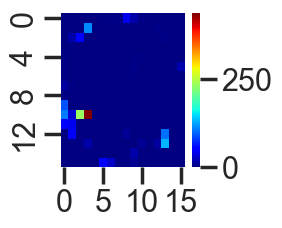

C:\Users\fentonlab\AppData\Local\Temp\ipykernel_26312\2977194271.py:22: RuntimeWarning: invalid value encountered in divide
  rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]


Place info [0.1360883  0.1991988  0.1421569  0.28416554 0.12029715 0.2076099
 0.11876295 0.19815467 0.30385202 0.06074089 0.16363236 0.2417525
 0.47730845 0.72819272 3.71159312 2.05350833 1.45604318 1.77112766
 1.19418658 0.93115875 0.15497903 0.33759181 1.21730222 1.24468757
 0.15705539 0.55651581 0.2825719  1.51306636 0.58613238 1.24528244
 1.44620189 2.16544421 1.34721852 0.10826509 0.04407853 0.04402136
 0.06140433 0.07750166 0.05324693 0.3595172  2.84043548 1.31246028
 0.13435991 1.61978348 1.09181616 0.26344672 0.05369682 0.89056395
 0.10586165 0.3025781  0.93640489 0.11157383 0.15062807 0.05107873
 0.65395016 0.07564108 0.06698947 0.13450051 0.10822657 0.0789317
 0.08791382 0.10944471 0.92665362 1.82929427 0.36699705 0.10820464
 1.39915853 0.47579855 0.10814898 0.07098279 0.06626973 0.23211498
 0.27953959 0.17433342 0.20643805 2.68380439 0.         3.07335105
 0.         1.34123651 0.05026763 0.26531787 0.21585582 0.03929647
 0.12748772 0.35785789 0.08712386 1.36638076 1.4017040

C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: divide by zero encountered in log2
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in multiply
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in divide
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\.conda\envs\bettinumbers\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


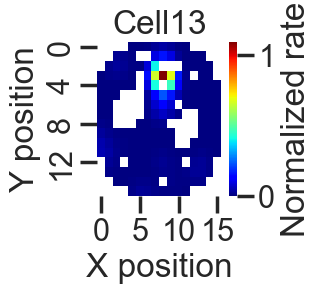

place information 1.7711276562880327
coherence 0.4819375464838577
firing rate 0.008333333333333333


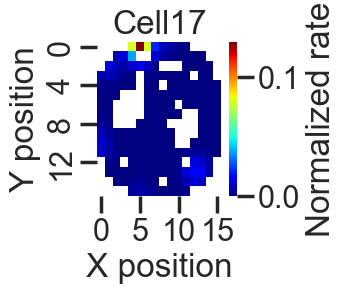

place information 1.194186575663202
coherence 0.40007656654045654
firing rate 0.019444444444444445


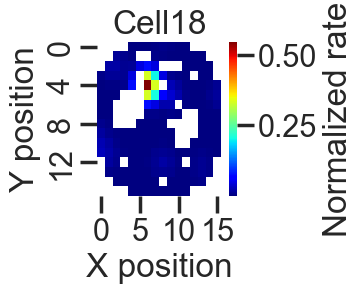

place information 0.9311587488581492
coherence 0.40992664926914835
firing rate 4.526666666666666


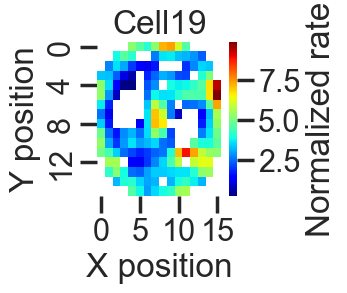

place information 1.2173022200066181
coherence 0.4829055994234113
firing rate 0.013333333333333334


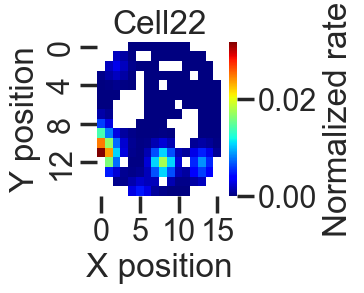

place information 1.2446875731528393
coherence 0.40209022673018285
firing rate 0.006111111111111111


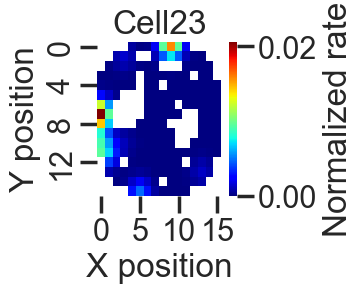

place information 1.5130663598883922
coherence 0.6434098412766421
firing rate 0.008333333333333333


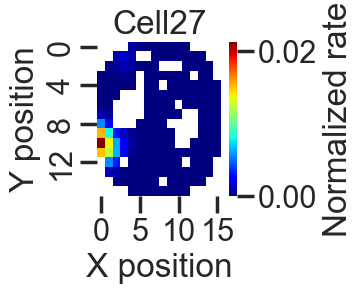

place information 1.4462018913835335
coherence 0.402755926288289
firing rate 0.023333333333333334


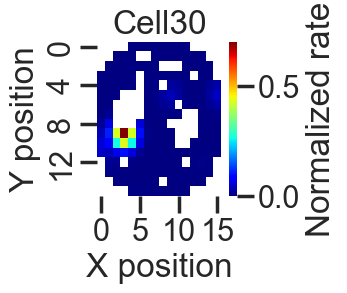

place information 1.347218519083925
coherence 0.4443073460858683
firing rate 0.01


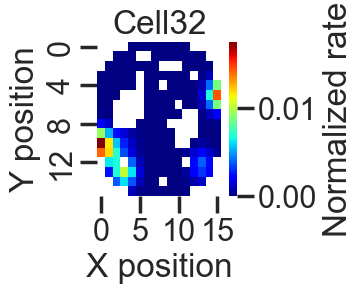

place information 2.8404354794756137
coherence 0.4522228027122113
firing rate 0.0038888888888888888


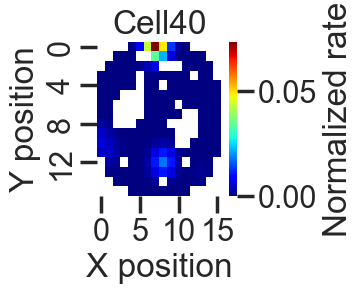

place information 1.3124602786870472
coherence 0.43071634435851575
firing rate 0.03111111111111111


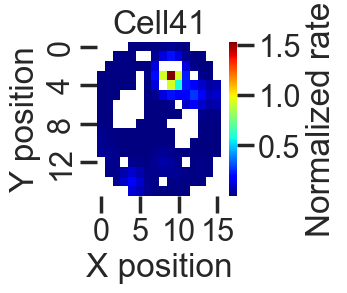

place information 1.3991585285482355
coherence 0.5775709930289832
firing rate 1.7472222222222222


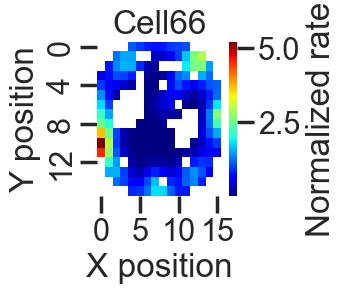

place information 2.6838043865176706
coherence 0.464611648422529
firing rate 0.006666666666666667


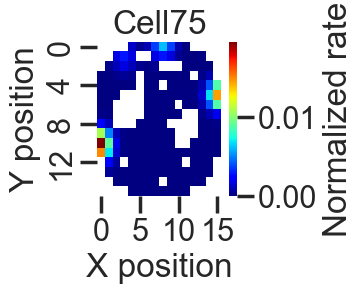

place information 3.0733510520694622
coherence 0.40191645740136916
firing rate 0.0033333333333333335


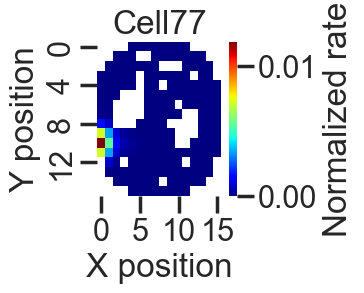

place information 1.3412365128647696
coherence 0.4047725447182811
firing rate 0.0044444444444444444


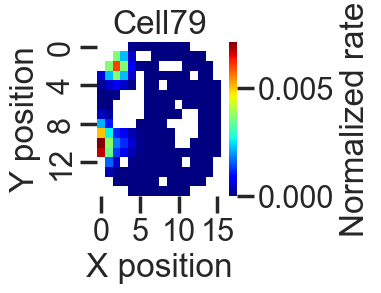

place information 1.4017040746617182
coherence 0.40071879881457717
firing rate 0.03


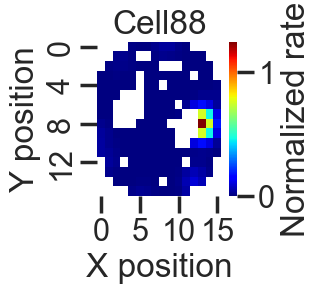

place information 0.894571214266131
coherence 0.5653668338785364
firing rate 0.3472222222222222


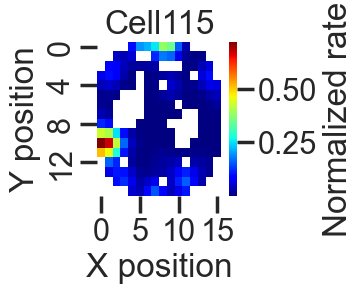

place information 1.336320430028706
coherence 0.5225220504208103
firing rate 0.03777777777777778


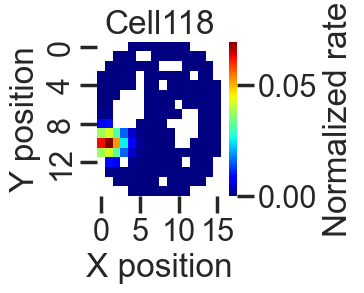

place information 2.8840836669153758
coherence 0.467097640921672
firing rate 0.03888888888888889


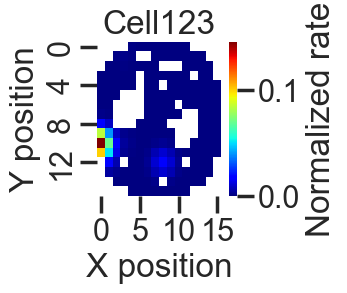

place information 2.7117800884878283
coherence 0.4977564216434994
firing rate 0.013888888888888888


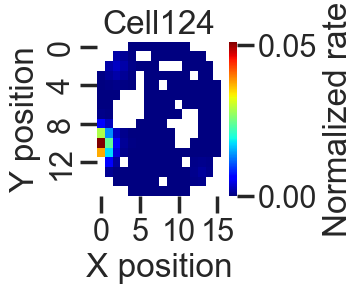

place information 2.0449174504656256
coherence 0.5631747366877953
firing rate 1.085


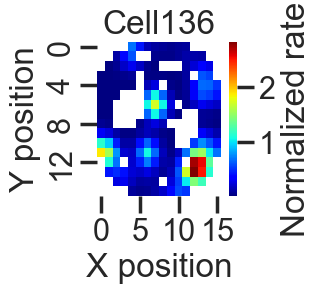

place information 1.4537311629815675
coherence 0.5678382152203342
firing rate 0.013333333333333334


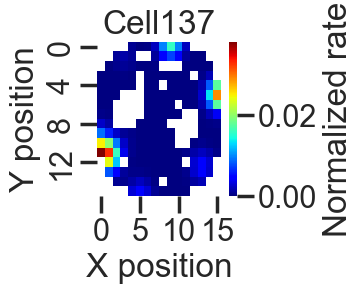

place information 1.2102022223063607
coherence 0.50970444002556
firing rate 0.8311111111111111


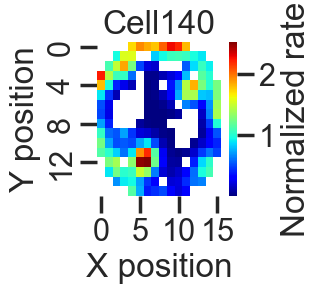

place information 1.6937733112076683
coherence 0.5895761584477796
firing rate 0.6544444444444445


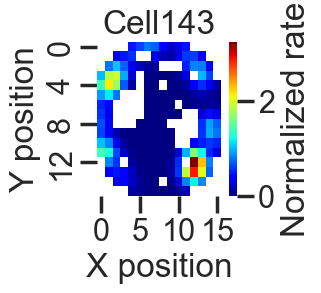

place information 1.558018661664391
coherence 0.41889939540443255
firing rate 0.3016666666666667


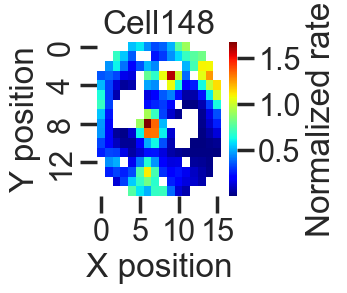

place information 1.3127960498546614
coherence 0.4420991285751766
firing rate 0.01611111111111111


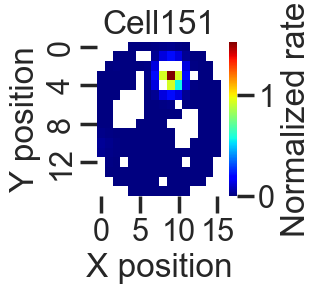

place information 1.406069290454819
coherence 0.40189931940164625
firing rate 0.012222222222222223


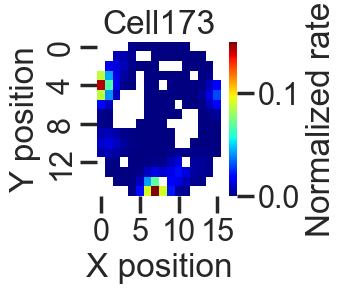

place information 1.5516568166513405
coherence 0.5195350775374272
firing rate 0.009444444444444445


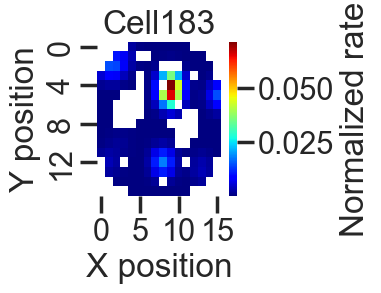

place information 2.5510043165236542
coherence 0.40750015445845034
firing rate 0.0022222222222222222


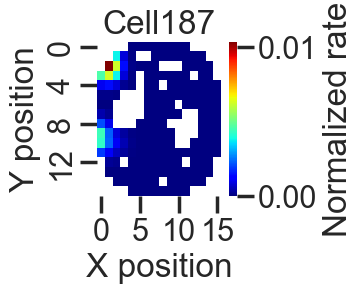

place information 0.9027991851092741
coherence 0.4700584055985589
firing rate 0.10666666666666667


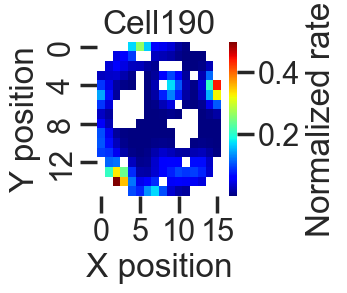

place information 0.8955229477369455
coherence 0.434416628493326
firing rate 0.13777777777777778


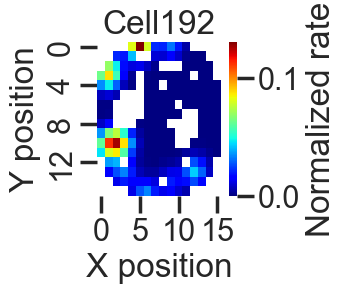

place information 1.5014226091014327
coherence 0.4821938189534889
firing rate 0.0022222222222222222


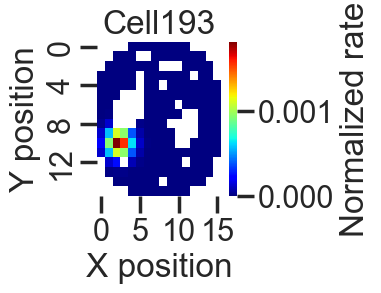

place information 2.146576723089957
coherence 0.43592076778093874
firing rate 0.011666666666666667


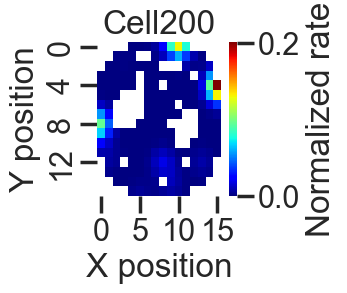

place information 3.665313876135678
coherence 0.4512885555249864
firing rate 0.11555555555555555


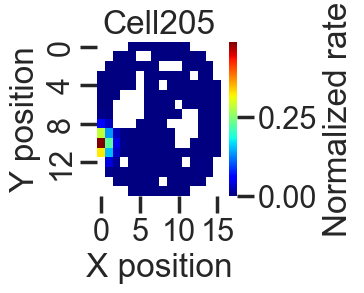

place information 2.250424910352857
coherence 0.4060029945944139
firing rate 0.007222222222222222


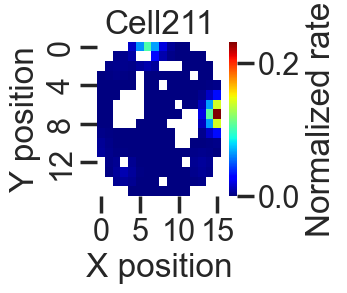

In [50]:
####
bins_position = 16
ls_tmp = []
fr_maps_all = []
PC_test_b_all = []
irec = sess
# for irec in range(0,1): #len(x)):
    
#     if (drug_list[irec] == 'SAL') or (drug_list[irec] == 'PCP') or (drug_list[irec] == 'RSK'):
#     if (mouse_list[irec] == 'M15'):


ksort_path = ksort_HPC_path_matched[irec]
print('experiment',ksort_path)

size_to = []
size_to = np.min([spikes_binned_all_HPC[0].shape[1],beh_binned_all[irec][0].size]) - 1



# # baseline
start = 0
end = 30*60*250
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = [], [],[],[],[],[],[]   
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = place_cell_properties(spikes_binned_all_HPC[0][:,start:end],
                                                                  np.array([beh_binned_all[irec][0][start:end],
                                                                            beh_binned_all[irec][1][start:end]]),
                                                                            bins_position,250,False)

PC_test_b_all.append(PC_test_b)

In [415]:
spk[2] - 150 >= 0



array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [418]:
250*60

15000

In [429]:
spk_short = spk[0][1:50][0:1000]
spk_short.shape[0]

49

In [447]:
# Save current print options
saved_options = np.get_printoptions()
# Set the print options to display the full array without truncation
np.set_printoptions(threshold=100)
# Restore the original print options
np.set_printoptions(**saved_options)

In [448]:
spk_short[0:5,0:250*60]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

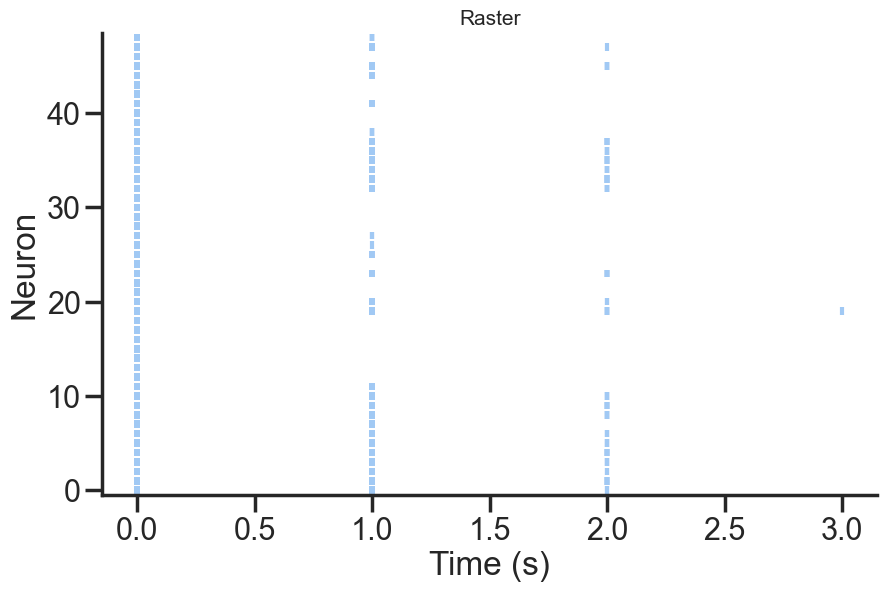

In [440]:
nCells = spk_short.shape[0]

# Create lists to hold the x and y values for the spikes
spike_times_x = []
spike_neurons_y = []


# Plot all spikes at once
plt.figure(figsize=(10, 6))
plt.eventplot(spk_short[:,0:250*60], linelengths=0.8)

# Set the limits and labels
plt.ylim(-0.5, nCells - 0.5)
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

# Add y-ticks to show neuron numbers
plt.yticks(np.arange(0,nCells,10))
plt.yticks(np.arange(0,nCells,10))

# Show the raster plot
plt.title('Raster', fontsize=15)
plt.show()

In [307]:
np.arange(0,len(bin_edges) - 1, 5)

array([ 0,  5, 10, 15, 20, 25])

In [312]:
bin_edges[::5]

array([  0.,  60., 120., 180., 240., 300., 360.])

In [325]:
bins = np.round(bin_edges[:-1], 2)
bins[::5]

array([  0.,  60., 120., 180., 240., 300.])

In [330]:
hist_B_arr

array([[ 7,  8,  6,  8,  6,  6,  9,  5,  9,  5,  4,  3,  4,  7,  8, 10,
         4,  7,  5,  8,  5,  8, 10, 10,  6,  6,  6,  5,  4, 14],
       [ 8,  7,  7,  7,  6,  8,  3,  6,  5,  2,  6,  8, 12,  9,  8,  3,
         5, 10, 12,  8,  5,  2,  8, 11,  8,  7,  3,  2,  7, 10],
       [ 8,  7,  5,  7,  4, 10,  4,  7,  2,  6,  4,  5, 10,  7,  7,  9,
         2,  7,  5,  7, 10,  7, 14,  9,  4,  8,  6,  7,  7,  8],
       [ 9,  3,  8,  6,  9,  6, 11,  4,  8,  3,  6,  5,  8,  9,  8,  7,
         5,  5, 10, 11,  2,  9,  6,  6,  6,  8,  5,  6,  8,  6],
       [ 4,  9, 11,  7,  9,  8,  8,  6,  7,  7,  5,  7,  6,  5,  4,  2,
         3,  7,  5,  9,  8,  6, 11,  8,  7, 10,  6,  8,  3,  7],
       [12,  7,  4,  6, 13,  7,  6, 10,  4,  7,  7,  6,  7,  8,  6,  6,
         2,  6,  5,  4,  1,  8,  6, 13,  9,  5,  6,  5, 11,  6],
       [ 5,  9,  6,  6,  9,  7, 12,  3,  2,  2,  5,  8, 11,  6, 10,  3,
         6,  6,  7,  4,  9,  4,  9,  4,  5,  8, 11,  4, 15,  7],
       [10,  4,  8,  5,  7,  8,  4,  7,  

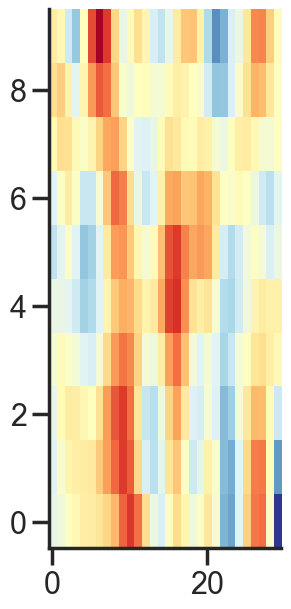

In [353]:
step = 5
fstep = 2
row_totals = np.sum(hist_B_arr, axis=1)

pdf = hist_B_arr / row_totals[:, np.newaxis]
pdf_sm = gaussian_filter(np.nan_to_num(pdf), sigma=1)
# Plotting the heatmap
plt.figure(figsize=(3,7))
plt.imshow(pdf_sm, cmap='RdYlBu', interpolation='nearest', origin='lower',aspect='auto')
bins = np.round(bin_edges[:-1], 2)
# plt.xticks(ticks=np.arange(0,len(bin_edges) - 1, step), labels=bins[::step])
# plt.yticks(ticks=np.arange(1,len(freq[:,0]),fstep), labels=freq[::fstep,0])
# plt.colorbar(label='Probability')
plt.show()

In [192]:
epoch_length = 250*60*30
# filter Lfp at a given epoch and 
lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B[:,lfp_ch].reshape(-1, 1), Lfp_L[:,lfp_ch].reshape(-1, 1), Lfp_M[:,lfp_ch].reshape(-1, 1), Lfp_H[:,lfp_ch].reshape(-1, 1), 1, 4, gain)
phase_B, phase_L, phase_M, phase_H = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H) 

lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B[:,lfp_ch].reshape(-1, 1), Lfp_L[:,lfp_ch].reshape(-1, 1), Lfp_M[:,lfp_ch].reshape(-1, 1), Lfp_H[:,lfp_ch].reshape(-1, 1), 1, 4, gain)

Filtering Lfp ...


In [196]:
lfp_filt_B.shape

(450000, 1)

In [197]:
phase_B, phase_L, phase_M, phase_H = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H)

In [202]:
spk[0][cell][0:epoch_length].shape

(450000,)

In [205]:

# Calculate the histogram, using spike counts as weights
hist_B, bin_edges = np.histogram(phase_B, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_L, bin_edges = np.histogram(phase_L, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_M, bin_edges = np.histogram(phase_M, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_H, bin_edges = np.histogram(phase_H, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))


In [206]:
hist_B, hist_L, hist_M, hist_H

(array([215, 267, 205, 205, 199, 226, 185, 240, 223, 251, 241, 223, 220,
        214, 174, 251, 257, 242, 294, 232, 264, 239, 222, 242, 261, 184,
        206, 209, 243, 199], dtype=int64),
 array([232, 224, 231, 224, 233, 227, 282, 198, 253, 237, 225, 250, 180,
        217, 248, 229, 203, 228, 233, 225, 237, 216, 264, 287, 235, 219,
        211, 203, 228, 154], dtype=int64),
 array([237, 211, 216, 221, 239, 270, 221, 226, 225, 213, 222, 248, 264,
        223, 217, 220, 221, 208, 263, 225, 204, 235, 198, 202, 233, 230,
        234, 230, 217, 260], dtype=int64),
 array([227, 204, 199, 218, 234, 295, 217, 219, 208, 241, 234, 247, 195,
        226, 175, 252, 198, 253, 221, 237, 260, 216, 214, 245, 251, 200,
        184, 244, 245, 274], dtype=int64))

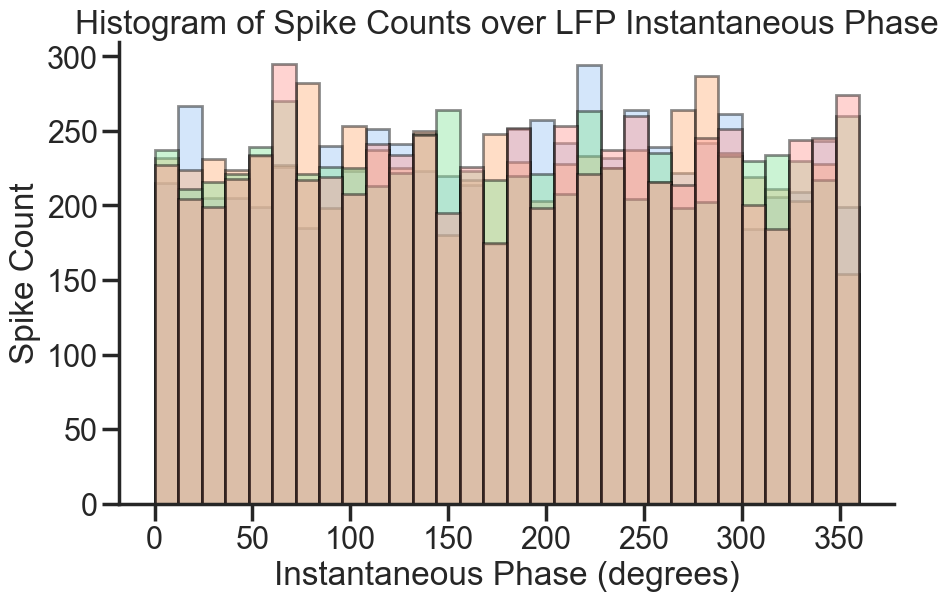

In [212]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_B, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_L, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_M, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_H, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.xlabel('Instantaneous Phase (degrees)')
plt.ylabel('Spike Count')
plt.title('Histogram of Spike Counts over LFP Instantaneous Phase')
plt.show()

In [ ]:
LinMapsTemp_temp = [np.histogram(alpha, bins=30, weights=s)[0] / L_occ
    #      for s in spk_data]

In [104]:
spk[0][0][0:1500]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

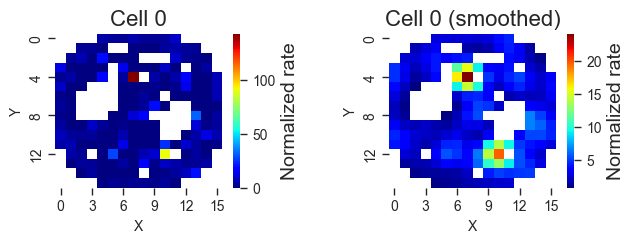

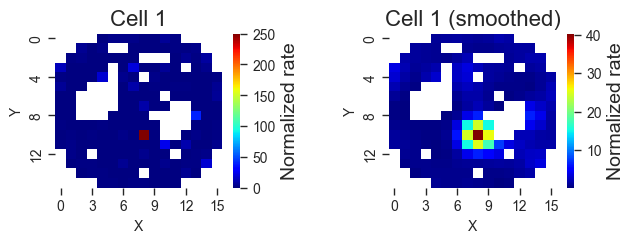

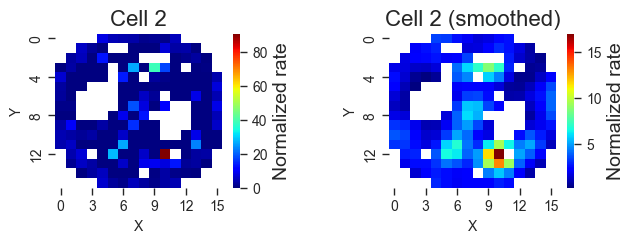

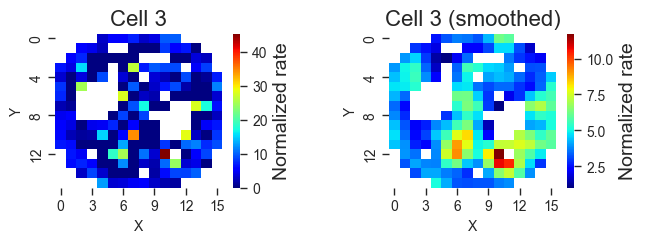

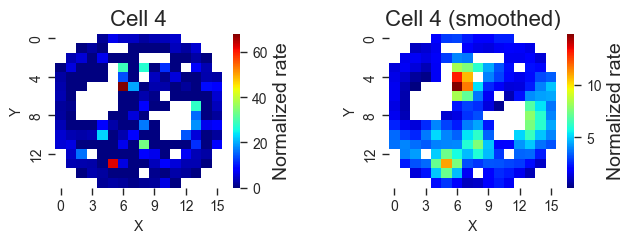

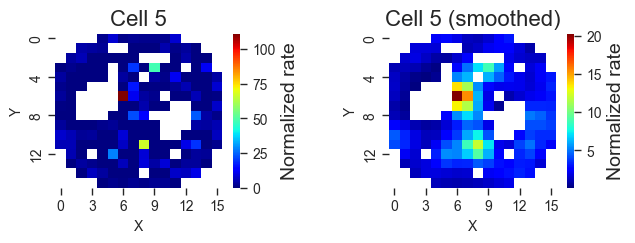

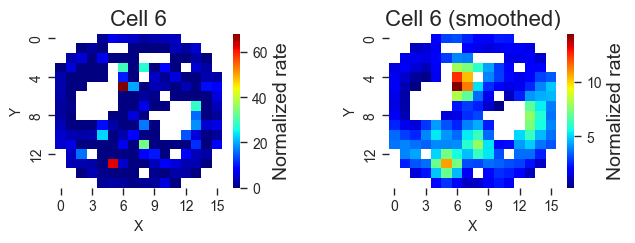

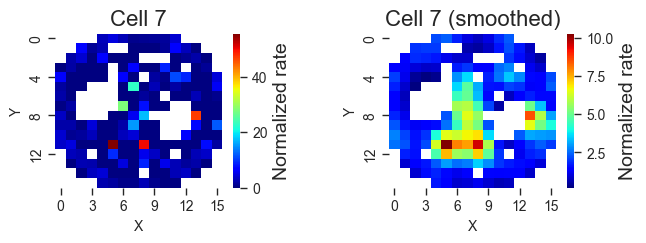

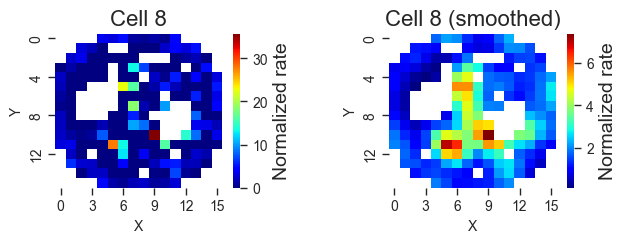

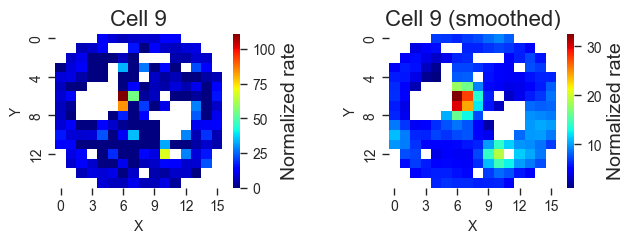

In [56]:
# ## plot firing rate maps
# for icell in range(0,len(rate_maps_temp_b)):
#     fig = plt.figure(figsize=(2, 2))
#     ax = fig.add_subplot(1, 1, 1)
#     sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#     ax.set_xlabel('X position')
#     ax.set_ylabel('Y position')
#     fname = 'Cell' + str(icell)
#     ax.set_title(fname)
#     plt.show()   
    

for icell in range(0,10): #len(rate_maps_temp_b)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
    
    # Plot for the first column
    heatmap1 = sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=axes[0], cbar_kws={'label': 'Normalized rate'})
    axes[0].set_xlabel('X',fontsize=10)
    axes[0].set_ylabel('Y',fontsize=10)
    axes[0].tick_params(axis='both', labelsize=10, width=1, length=5)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=10)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=10)
    axes[0].set_title('Cell ' + str(icell), fontsize=16)
    
    cbar = heatmap1.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10, width=1, length=5)

    # Plot for the second column (assuming a replication of the first for demonstration)
    heatmap2 = sns.heatmap(rate_maps_temp_b_sm[icell], cmap='jet', ax=axes[1], cbar_kws={'label': 'Normalized rate'})
    axes[1].set_xlabel('X',fontsize=10)
    axes[1].set_ylabel('Y',fontsize=10)
    axes[1].tick_params(axis='both', labelsize=10, width=1, length=5)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=10)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=10)
    axes[1].set_title('Cell ' + str(icell) + ' (smoothed)', fontsize=16)
    
    cbar = heatmap2.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10, width=1, length=5)
    
    plt.subplots_adjust(wspace=0.6)  # Adjust space between plots. You can modify the value as per your requirements.
    plt.show()


In [126]:
LfpS.shape[0]/250/60

120.0334